<a href="https://colab.research.google.com/github/gharashim/DL/blob/main/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 84% 683M/812M [00:00<00:00, 1.39GB/s]
100% 812M/812M [00:00<00:00, 1.25GB/s]


In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)

        frames = list(original_dir.glob(f"{category}.*.jpg"))[start_index:end_index]
        for frame in frames:
            shutil.copy(frame, dir / frame.name)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.4830 - loss: 0.7171 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5323 - loss: 0.6915 - val_accuracy: 0.5500 - val_loss: 0.6864
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5560 - loss: 0.6905 - val_accuracy: 0.5740 - val_loss: 0.6582
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5795 - loss: 0.6726 - val_accuracy: 0.6460 - val_loss: 0.6539
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6290 - loss: 0.6377 - val_accuracy: 0.6720 - val_loss: 0.6155
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6647 - loss: 0.6117 - val_accuracy: 0.6650 - val_loss: 0.6210
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6912 - loss: 0.5863 - val_accuracy: 0.6490 - val_loss: 0.6412
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7095 - loss: 0.5715 - val_accuracy: 0.6120 -

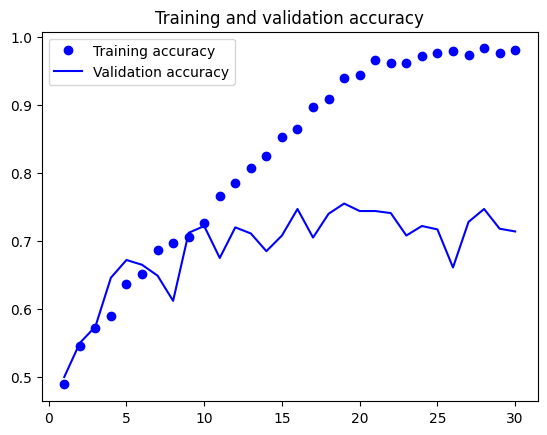

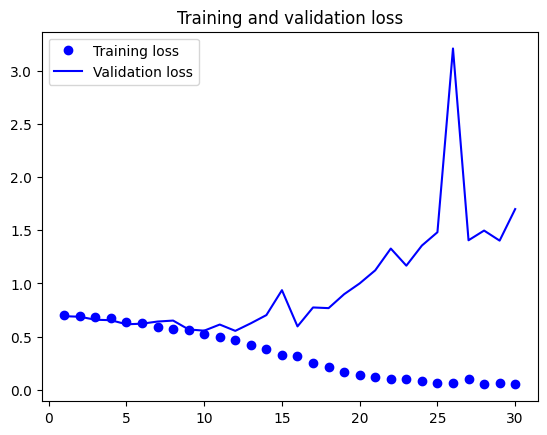

In [9]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [10]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7173 - loss: 0.5872
Test accuracy: 0.718


# 데이터 증식 사용

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

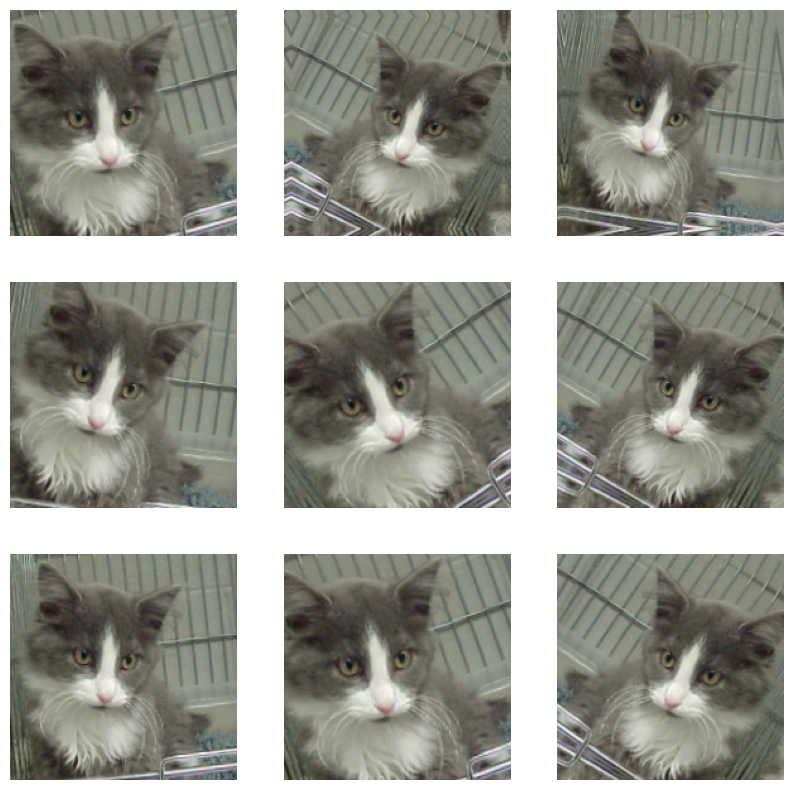

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [23]:
inputs = keras.Input(shape = (180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4622 - loss: 0.7249

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4632 - loss: 0.7239 - val_accuracy: 0.4990 - val_loss: 0.6909
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5599 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.7195
Epoch 3/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5797 - loss: 0.6830

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5800 - loss: 0.6827 - val_accuracy: 0.6220 - val_loss: 0.6671
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6077 - loss: 0.6577 - val_accuracy: 0.5800 - val_loss: 0.6867
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6169 - loss: 0.6527 - val_accuracy: 0.5710 - val_loss: 0.7505
Epoch 6/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6570 - loss: 0.6353

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6560 - loss: 0.6356 - val_accuracy: 0.6580 - val_loss: 0.6438
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6405 - loss: 0.6315

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6407 - loss: 0.6314 - val_accuracy: 0.6520 - val_loss: 0.6418
Epoch 8/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6696 - loss: 0.6057

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6693 - loss: 0.6064 - val_accuracy: 0.6850 - val_loss: 0.5936
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6807 - loss: 0.5874 - val_accuracy: 0.6760 - val_loss: 0.6288
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7027 - loss: 0.5745 - val_accuracy: 0.6770 - val_loss: 0.5940
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6934 - loss: 0.5769 - val_accuracy: 0.6270 - val_loss: 0.7032
Epoch 12/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6907 - loss: 0.5680

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6912 - loss: 0.5682 - val_accuracy: 0.6800 - val_loss: 0.5845
Epoch 13/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7034 - loss: 0.5543

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7037 - loss: 0.5546 - val_accuracy: 0.7540 - val_loss: 0.5341
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7060 - loss: 0.5515 - val_accuracy: 0.7250 - val_loss: 0.5478
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7209 - loss: 0.5462 - val_accuracy: 0.6880 - val_loss: 0.5710
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7171 - loss: 0.5447 - val_accuracy: 0.7410 - val_loss: 0.5436
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7389 - loss: 0.5268 - val_accuracy: 0.6980 - val_loss: 0.5806
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7322 - loss: 0.5261 - val_accuracy: 0.6940 - val_loss: 0.6039
Epoch 19/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7546 - loss: 0.5090 - val_accuracy: 0.6780 - val_loss: 0.5984
Epoch 20/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7396 - loss: 0.5084

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7397 - loss: 0.5090 - val_accuracy: 0.7710 - val_loss: 0.4916
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7833 - loss: 0.4703 - val_accuracy: 0.7490 - val_loss: 0.5438
Epoch 22/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7431 - loss: 0.4959

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7438 - loss: 0.4957 - val_accuracy: 0.7670 - val_loss: 0.4851
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7860 - loss: 0.4576 - val_accuracy: 0.7670 - val_loss: 0.4978
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7764 - loss: 0.4671 - val_accuracy: 0.7540 - val_loss: 0.5114
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7844 - loss: 0.4473 - val_accuracy: 0.7590 - val_loss: 0.4949
Epoch 26/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7823 - loss: 0.4610

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7825 - loss: 0.4608 - val_accuracy: 0.7620 - val_loss: 0.4834
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7815 - loss: 0.4686 - val_accuracy: 0.7800 - val_loss: 0.4994
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7831 - loss: 0.4441 - val_accuracy: 0.7090 - val_loss: 0.6105
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7884 - loss: 0.4526 - val_accuracy: 0.7800 - val_loss: 0.5091
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7972 - loss: 0.4370 - val_accuracy: 0.7540 - val_loss: 0.5373
Epoch 31/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8005 - loss: 0.4368

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8008 - loss: 0.4370 - val_accuracy: 0.7750 - val_loss: 0.4728
Epoch 32/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7803 - loss: 0.4342

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7811 - loss: 0.4337 - val_accuracy: 0.7870 - val_loss: 0.4489
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8125 - loss: 0.4118 - val_accuracy: 0.7800 - val_loss: 0.4952
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7930 - loss: 0.4251 - val_accuracy: 0.7970 - val_loss: 0.4614
Epoch 35/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7925 - loss: 0.4344 - val_accuracy: 0.7770 - val_loss: 0.4707
Epoch 36/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8327 - loss: 0.3905 - val_accuracy: 0.7710 - val_loss: 0.5233
Epoch 37/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7989 - loss: 0.4057

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7998 - loss: 0.4053 - val_accuracy: 0.8200 - val_loss: 0.4036
Epoch 38/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8229 - loss: 0.4047 - val_accuracy: 0.7680 - val_loss: 0.4934
Epoch 39/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8223 - loss: 0.3885 - val_accuracy: 0.7670 - val_loss: 0.5504
Epoch 40/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8177 - loss: 0.3948 - val_accuracy: 0.7760 - val_loss: 0.4848
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8514 - loss: 0.3559 - val_accuracy: 0.7800 - val_loss: 0.4609
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8205 - loss: 0.4059 - val_accuracy: 0.8040 - val_loss: 0.4099
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8321 - loss: 0.3677 - val_accuracy: 0.8100 - val_loss: 0.4310
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8260 - loss: 0.3814 - val_accuracy: 0.7590 

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8643 - loss: 0.3042 - val_accuracy: 0.8270 - val_loss: 0.3983
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8808 - loss: 0.2802 - val_accuracy: 0.8370 - val_loss: 0.4252
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8779 - loss: 0.2711 - val_accuracy: 0.8380 - val_loss: 0.4079
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8951 - loss: 0.2548 - val_accuracy: 0.8360 - val_loss: 0.4408
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8811 - loss: 0.2779 - val_accuracy: 0.8020 - val_loss: 0.5258
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8837 - loss: 0.2783 - val_accuracy: 0.8260 - val_loss: 0.5390
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9004 - loss: 0.2472 - val_accuracy: 0.7590 - val_loss: 0.8021
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8871 - loss: 0.2855 - val_accuracy: 0.8180 

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8909 - loss: 0.2331 - val_accuracy: 0.8590 - val_loss: 0.3942
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8941 - loss: 0.2494 - val_accuracy: 0.8470 - val_loss: 0.4425
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8888 - loss: 0.2541 - val_accuracy: 0.8350 - val_loss: 0.4934
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8970 - loss: 0.2369 - val_accuracy: 0.8220 - val_loss: 0.6419
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8980 - loss: 0.2301 - val_accuracy: 0.7900 - val_loss: 0.7980
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8909 - loss: 0.2848 - val_accuracy: 0.8180 - val_loss: 0.5967
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8997 - loss: 0.2317 - val_accuracy: 0.8450 - val_loss: 0.4602
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9050 - loss: 0.2621 - val_accuracy: 0.8330 

In [25]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7955 - loss: 0.4676
Test accuracy: 0.804


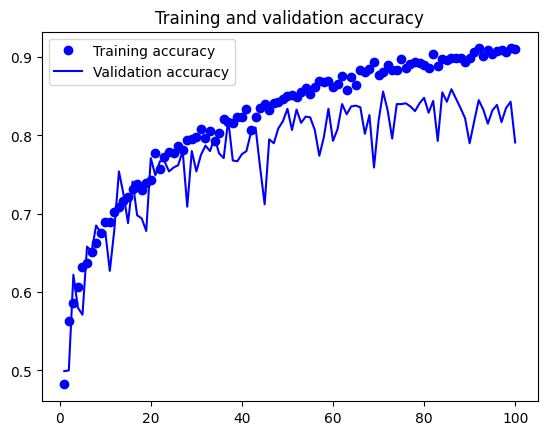

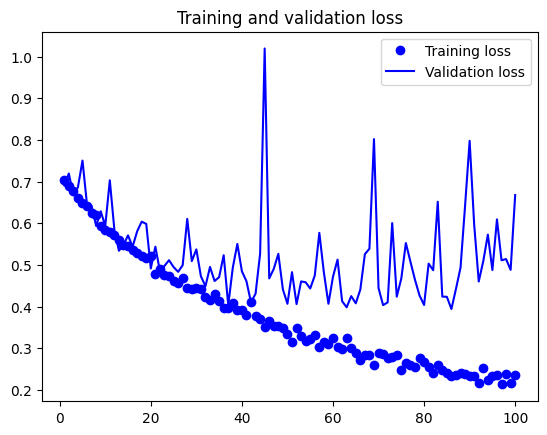

In [26]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()